<a href="https://colab.research.google.com/github/JuanM-GG/maestria/blob/main/estimacion-parametros/estimacion_parametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd  

In [90]:
#@title solver
def euler(f, x0, t0, tf, dt, u, *kargs):

    """
    Solve a system of differential equations using the Euler method.
    
    Parameters:
    f (function): The derivative function.
    x0 (ndarray): The initial state.
    t0 (float): The initial time.
    tf (float): The final time.
    dt (float): The time step.
    u (function): The input function.
    
    Returns:
    ndarray: The state at each time step.
    """
    t = np.arange(t0, tf, dt)
    x = np.zeros((len(t), len(x0)))
    x[0, :] = x0
    for i in range(1, len(t)):
        # print(x[i,:])
        x[i, :] = x[i-1, :] + dt * f(x[i-1, :], t[i-1], u(t[i-1]), *kargs)
    return x

In [91]:
#@title model
def monod_model(y, t, u,  mu_max, yxs, ks, ypx):
    x, s, p = y 

    growth_rate = mu_max*(s/(ks + s))

    dx = growth_rate*x 
    ds = -1/yxs*growth_rate*x
    dp = ypx*growth_rate*x

    return np.array([dx, ds, dp])

In [92]:
# Definir parametros 
mu_max = 1.2 # g/L
yxs = 0.2 
ks = 280 # g/L
ypx = 4 

In [93]:
# Definir condiciones iniciales 
x0 = np.array([0.2, 40, 0])

# Definir tiempo de integracion 
tf = 60 
dt = 1 
time = np.arange(0, tf+dt, dt)

# Simular ODEs
x, s, p = euler(monod_model, x0, 0, tf+dt, dt, lambda t: 0, mu_max, yxs, ks, ypx).T

In [94]:
# Funcion para obtener concentraciones finales
def final_conc(x, s, p):
    return (x[-1],p[-1],s[-1])

In [95]:
final_conc(x, s, p)

(8.188387294636055, 31.953549178544236, 0.0580635268197149)

(8.185185831258408, 31.94074332503364, 0.07407084370789976)

In [96]:
# Funcion para generar df con simulacion
def generate_data(time, x, s, p):
    predicted = {'t': [], 'x':[], 's':[], 'p':[]}
    for i in range(len(time)):

        predicted['t'].append(time[i])
        predicted['x'].append(x[i])
        predicted['s'].append(s[i])
        predicted['p'].append(p[i])

    predicted = pd.DataFrame(predicted)
    return predicted

In [97]:
predicted = generate_data(time, x, s, p)
predicted.head()

,t,x,s,p
0,0,0.200000,40.000000,0.000000
1,1,0.230000,39.850000,0.120000
2,2,0.264387,39.678066,0.257547
3,3,0.303765,39.481174,0.415061
4,4,0.348812,39.255940,0.595248


In [98]:
def plot_data(data):
    plt.figure(figsize=(10,5))
    plt.plot(data.t, data.x, label='x')
    plt.plot(data.t, data.s, label='s')
    plt.plot(data.t, data.p, label='p')
    plt.ylabel('Concentraciones (g/L)')
    plt.xlabel('Tiempo (h)')
    plt.grid()
    plt.legend()
    plt.show()

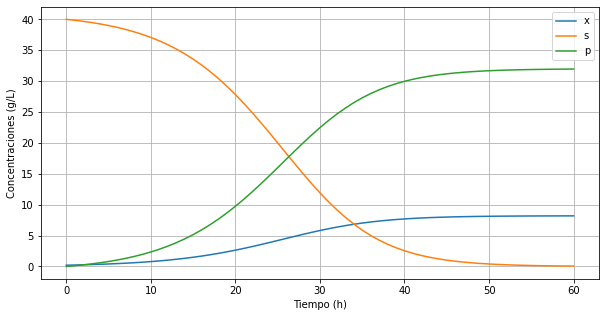

In [99]:
plot_data(predicted)

In [100]:
# Funcion para agragar ruido a los datos
def add_noise(predicted, x_noise, s_noise, p_noise):

    predicted_noise = predicted.copy() 

    predicted_noise.x = predicted_noise.x + np.random.normal(loc=0, scale=x_noise, size=len(predicted_noise.x))
    predicted_noise.s = predicted_noise.s + np.random.normal(loc=0, scale=s_noise, size=len(predicted_noise.s))
    predicted_noise.p = predicted_noise.p + np.random.normal(loc=0, scale=p_noise, size=len(predicted_noise.p))

    return predicted_noise


In [101]:
predicted_noise = add_noise(predicted, 0.1, 1, 1)

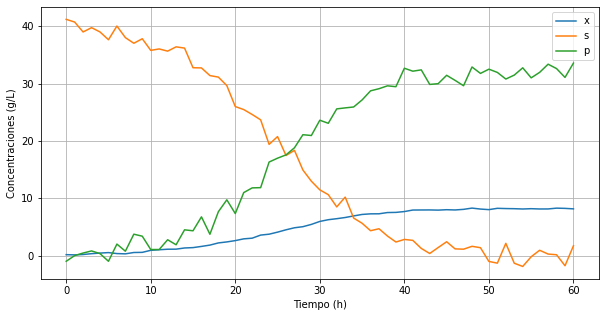

In [102]:
plot_data(predicted_noise)

In [103]:
#@title load data
# data = {'t': [], 'x':[], 's':[], 'p':[]}
# with open("simulation_data.csv", "r") as f:
#     print(f.readline())
#     for line in f:
#         t_d, x_d, p_d, s_d = line.split(',')
        
#         data['t'].append(int(t_d))
#         data['x'].append(float(x_d))
#         data['s'].append(float(s_d))
#         data['p'].append(float(p_d))
        
# data = pd.DataFrame(data)
# print(data.shape)
# print(predicted.shape)
# data.head()

In [104]:
# Funcion para evaluar el costo
def cost_function(data, predicted):
    data = np.array(data)
    predicted = np.array(predicted)
    return np.sum((data - predicted)**2)/len(data)

In [119]:
def fitness_function(parms):
    mu_max, yxs, ks, ypx = parms
    x, s, p = euler(monod_model, x0, 0, tf+dt, dt, lambda t: 0, mu_max, yxs, ks, ypx).T
    out = generate_data(time, x, s, p)
    return cost_function(predicted_noise, out)

In [120]:
fitness_function([mu_max, yxs, ks, ypx])

2.385009056956527

In [110]:
pip install geneticalgorithm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15096 sha256=4c8eea0c845b36689710a0756756c91e3042ba63c89b4dc94c9f6a77d085f7db
  Stored in directory: /root/.cache/pip/wheels/a8/92/ca/5bbab358275e310af23b73fc32ebf37d6a7a08c87c8d2cdbc1
Successfully built func-timeout


In [111]:
# Configuramos algoritmo genetico
algorithm_param = {'max_num_iteration': 100,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

In [112]:
# Importar libreria de algoritmos geneticos
from geneticalgorithm import geneticalgorithm as ga

In [113]:
# Establecer los rangos de busqueda para las variables de decision
varbound=np.array([
    [0,1], # mu_max
    [10,20], # ks
    [0,1], # yxs
    [10,20] # ypx
])

In [121]:
# LLamar el algortimo genetico para realizar la optimizacion
model=ga(function=fitness_function,
         dimension=4,
         variable_type='real',
         variable_boundaries=varbound,
         algorithm_parameters=algorithm_param)

 The best solution found:
 [ 0.05315949 10.10631607  0.9940545  13.20426135]

 Objective function:
 884.044322226996


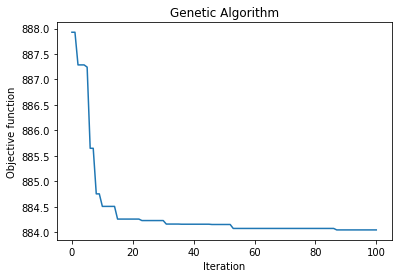

In [122]:
# Realizar la busqueda
model.run()